# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally
written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you can select your final model/hyperparameters to run one time only and then make the business perfoemance tables for that final model.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [46]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [47]:
import os 
os.getcwd()

'/Users/chaitanya/Desktop/second sem/Fraud Analytics/Assignment-10'

In [48]:
%%time
vars = pd.read_csv('model_variables.csv')
print(vars.shape)
vars.head()

(96397, 52)
CPU times: user 298 ms, sys: 53.7 ms, total: 352 ms
Wall time: 372 ms


,Recnum,Fraud,Cardnum_avg_0,Cardnum_max_0,Cardnum_med_0,Cardnum_total_0,Cardnum_med_1,Cardnum_total_1,Cardnum_med_3,Cardnum_total_3,...,Card_Merchnum_desc_avg_0,Card_Merchnum_desc_max_0,Card_Merchnum_desc_med_0,Card_Merchnum_desc_total_0,Card_Merchnum_desc_avg_1,Card_Merchnum_desc_max_1,Card_Merchnum_desc_med_1,Card_Merchnum_desc_avg_3,Card_Merchnum_desc_max_7,amount_cat
0,1,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,1
1,2,0,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,...,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,2
2,3,0,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,...,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,3
3,4,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,1
4,5,0,3.62,3.62,3.62,7.24,3.62,7.24,3.62,7.24,...,3.62,3.62,3.62,7.24,3.62,3.62,3.62,3.62,3.62,1


In [49]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 20

vars.rename(columns={'record':'Recnum'},inplace=True)
vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'Recnum',
 'Fraud',
 'Cardnum_avg_0',
 'Cardnum_max_0',
 'Cardnum_med_0',
 'Cardnum_total_0',
 'Cardnum_med_1',
 'Cardnum_total_1',
 'Cardnum_med_3',
 'Cardnum_total_3',
 'Merchnum_total_0',
 'Merchnum_total_1',
 'card_merch_avg_0',
 'card_merch_max_0',
 'card_merch_med_0',
 'card_merch_total_0',
 'card_merch_avg_1',
 'card_merch_max_1',
 'card_merch_med_1',
 'card_merch_max_7']

In [50]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,Recnum,Fraud,Cardnum_avg_0,Cardnum_max_0,Cardnum_med_0,Cardnum_total_0,Cardnum_med_1,Cardnum_total_1,...,Merchnum_total_0,Merchnum_total_1,card_merch_avg_0,card_merch_max_0,card_merch_med_0,card_merch_total_0,card_merch_avg_1,card_merch_max_1,card_merch_med_1,card_merch_max_7
0,1,0,1,0,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
1,2,0,2,0,31.42,31.42,31.42,31.42,31.42,31.42,...,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42
2,3,0,3,0,178.49,178.49,178.49,178.49,178.49,178.49,...,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49
3,4,0,4,0,3.62,3.62,3.62,3.62,3.62,3.62,...,7.24,7.24,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
4,5,0,5,0,3.62,3.62,3.62,7.24,3.62,7.24,...,10.86,10.86,3.62,3.62,3.62,7.24,3.62,3.62,3.62,3.62


In [51]:
vars.shape

(96397, 22)

In [52]:
vars['Fraud'].sum()

Fraud    1059
Fraud    1059
dtype: int64

In [53]:
vars.head(10)

,Recnum,Fraud,Recnum,Fraud,Cardnum_avg_0,Cardnum_max_0,Cardnum_med_0,Cardnum_total_0,Cardnum_med_1,Cardnum_total_1,...,Merchnum_total_0,Merchnum_total_1,card_merch_avg_0,card_merch_max_0,card_merch_med_0,card_merch_total_0,card_merch_avg_1,card_merch_max_1,card_merch_med_1,card_merch_max_7
0,1,0,1,0,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
1,2,0,2,0,31.42,31.42,31.42,31.42,31.42,31.42,...,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42
2,3,0,3,0,178.49,178.49,178.49,178.49,178.49,178.49,...,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49
3,4,0,4,0,3.62,3.62,3.62,3.62,3.62,3.62,...,7.24,7.24,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
4,5,0,5,0,3.62,3.62,3.62,7.24,3.62,7.24,...,10.86,10.86,3.62,3.62,3.62,7.24,3.62,3.62,3.62,3.62
5,6,0,6,0,3.67,3.67,3.67,3.67,3.67,3.67,...,14.53,14.53,3.67,3.67,3.67,3.67,3.67,3.67,3.67,3.67
6,7,0,7,0,3.62,3.62,3.62,3.62,3.62,3.62,...,18.15,18.15,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
7,8,0,8,0,230.32,230.32,230.32,230.32,230.32,230.32,...,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32
8,9,0,9,0,62.11,62.11,62.11,62.11,62.11,62.11,...,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11
9,10,0,10,0,3.62,3.62,3.62,10.86,3.62,10.86,...,21.77,21.77,3.62,3.62,3.62,10.86,3.62,3.62,3.62,3.62


In [54]:
vars.shape

(96397, 22)

In [55]:
vars.describe()

,Recnum,Fraud,Recnum,Fraud,Cardnum_avg_0,Cardnum_max_0,Cardnum_med_0,Cardnum_total_0,Cardnum_med_1,Cardnum_total_1,...,Merchnum_total_0,Merchnum_total_1,card_merch_avg_0,card_merch_max_0,card_merch_med_0,card_merch_total_0,card_merch_avg_1,card_merch_max_1,card_merch_med_1,card_merch_max_7
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,...,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,48365.481820,0.010986,48365.481820,0.010986,393.557490,498.205809,381.352185,741.645565,364.221874,1110.045587,...,777.305666,1115.435988,395.812357,421.261258,393.474975,528.698464,397.265458,432.494085,394.530092,458.733380
std,27945.003883,0.104236,27945.003883,0.104236,726.845846,1030.957360,718.729093,3431.446131,658.721561,5669.434127,...,2842.302519,4354.724591,796.953627,935.810708,790.655359,2621.824270,799.907434,1010.274250,794.435798,1022.760101
min,1.000000,0.000000,1.000000,0.000000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,24154.000000,0.000000,24154.000000,0.000000,42.835000,48.380000,38.800000,60.000000,44.000000,90.000000,...,89.850000,116.270000,34.990000,36.750000,34.700000,46.530000,35.500000,38.360000,35.000000,43.940000
50%,48365.000000,0.000000,48365.000000,0.000000,160.000000,191.930000,149.650000,220.000000,157.700000,339.160000,...,273.460000,390.000000,141.000000,147.980000,139.990000,159.110000,144.000000,150.000000,141.920000,168.300000
75%,72578.000000,0.000000,72578.000000,0.000000,453.900000,563.000000,427.500000,685.650000,411.525000,1043.110000,...,762.990000,1122.950000,435.300000,450.940000,431.820000,493.450000,438.940000,464.610000,434.170000,503.960000
max,96753.000000,1.000000,96753.000000,1.000000,28392.840000,47900.000000,28392.840000,218301.830000,28392.840000,307468.060000,...,217467.180000,306633.410000,28392.840000,47900.000000,28392.840000,217467.180000,28392.840000,47900.000000,28392.840000,47900.000000


In [56]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud']).iloc[:,0]
Y_save.head()

0    0
1    0
2    0
3    0
4    0
Name: Fraud, dtype: int64

## Scale and truncate field values

In [57]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,Cardnum_avg_0,Cardnum_max_0,Cardnum_med_0,Cardnum_total_0,Cardnum_med_1,Cardnum_total_1,Cardnum_med_3,Cardnum_total_3,Merchnum_total_0,Merchnum_total_1,card_merch_avg_0,card_merch_max_0,card_merch_med_0,card_merch_total_0,card_merch_avg_1,card_merch_max_1,card_merch_med_1,card_merch_max_7
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,393.557490,498.205809,381.352185,741.645565,364.221874,1110.045587,341.356881,1512.932952,777.305666,1115.435988,395.812357,421.261258,393.474975,528.698464,397.265458,432.494085,394.530092,458.733380
std,726.845846,1030.957360,718.729093,3431.446131,658.721561,5669.434127,592.648531,6115.505329,2842.302519,4354.724591,796.953627,935.810708,790.655359,2621.824270,799.907434,1010.274250,794.435798,1022.760101
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,42.835000,48.380000,38.800000,60.000000,44.000000,90.000000,48.260000,140.000000,89.850000,116.270000,34.990000,36.750000,34.700000,46.530000,35.500000,38.360000,35.000000,43.940000
50%,160.000000,191.930000,149.650000,220.000000,157.700000,339.160000,160.000000,518.610000,273.460000,390.000000,141.000000,147.980000,139.990000,159.110000,144.000000,150.000000,141.920000,168.300000
75%,453.900000,563.000000,427.500000,685.650000,411.525000,1043.110000,389.500000,1550.000000,762.990000,1122.950000,435.300000,450.940000,431.820000,493.450000,438.940000,464.610000,434.170000,503.960000
max,28392.840000,47900.000000,28392.840000,218301.830000,28392.840000,307468.060000,28392.840000,310843.060000,217467.180000,306633.410000,28392.840000,47900.000000,28392.840000,217467.180000,28392.840000,47900.000000,28392.840000,47900.000000


In [58]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [59]:
# use this to cap variables. For some problems it helps
Clip = 10

In [60]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
# Now redo the zscaling after clipping
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()
X.describe()

,Cardnum_avg_0,Cardnum_max_0,Cardnum_med_0,Cardnum_total_0,Cardnum_med_1,Cardnum_total_1,Cardnum_med_3,Cardnum_total_3,Merchnum_total_0,Merchnum_total_1,card_merch_avg_0,card_merch_max_0,card_merch_med_0,card_merch_total_0,card_merch_avg_1,card_merch_max_1,card_merch_med_1,card_merch_max_7
count,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04
mean,1.275734e-14,-6.703705e-15,-6.591276e-16,-3.692918e-15,4.128333e-15,-7.187159e-15,5.569597e-15,-5.322179e-15,-3.403113e-15,-1.591708e-15,1.200636e-14,-6.612972e-17,2.013220e-15,-1.095818e-15,1.251992e-14,-5.982286e-16,-4.367181e-15,-2.256658e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-5.414456e-01,-4.832361e-01,-5.305785e-01,-2.161292e-01,-5.529072e-01,-1.957930e-01,-5.759685e-01,-2.473913e-01,-2.734739e-01,-2.561416e-01,-4.966442e-01,-4.501458e-01,-4.976441e-01,-2.016491e-01,-4.966268e-01,-4.280858e-01,-4.966041e-01,-4.485151e-01
25%,-4.825266e-01,-4.363185e-01,-4.766082e-01,-1.986467e-01,-4.861263e-01,-1.799202e-01,-4.945543e-01,-2.245003e-01,-2.418658e-01,-2.294441e-01,-4.527520e-01,-4.108857e-01,-4.537691e-01,-1.839057e-01,-4.522592e-01,-3.901258e-01,-4.525603e-01,-4.055627e-01
50%,-3.213302e-01,-2.970790e-01,-3.223776e-01,-1.520192e-01,-3.135192e-01,-1.359722e-01,-3.060109e-01,-1.625905e-01,-1.772667e-01,-1.665860e-01,-3.197330e-01,-2.920262e-01,-3.206011e-01,-1.409661e-01,-3.166185e-01,-2.796212e-01,-3.179742e-01,-2.839702e-01
75%,8.301968e-02,6.284857e-02,6.420752e-02,-1.631836e-02,7.181050e-02,-1.180640e-02,8.123384e-02,6.061159e-03,-5.036644e-03,1.725485e-03,4.954823e-02,3.171447e-02,4.849777e-02,-1.344425e-02,5.209921e-02,3.178930e-02,4.989693e-02,4.422016e-02
max,3.852162e+01,4.597842e+01,3.897364e+01,6.340189e+01,4.255002e+01,5.403679e+01,4.733241e+01,5.058129e+01,7.623744e+01,7.015782e+01,3.513006e+01,5.073541e+01,3.541286e+01,8.274333e+01,3.499852e+01,4.698477e+01,3.524301e+01,4.638553e+01


In [61]:
len(X)

96397

In [62]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum=87397
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]

In [63]:
X_oot

,Cardnum_avg_0,Cardnum_max_0,Cardnum_med_0,Cardnum_total_0,Cardnum_med_1,Cardnum_total_1,Cardnum_med_3,Cardnum_total_3,Merchnum_total_0,Merchnum_total_1,card_merch_avg_0,card_merch_max_0,card_merch_med_0,card_merch_total_0,card_merch_avg_1,card_merch_max_1,card_merch_med_1,card_merch_max_7
87397,-0.239593,0.030306,-0.397023,-0.024309,-0.273366,-0.031664,-0.116522,0.267538,-0.087202,-0.134563,0.167686,0.115610,0.171978,0.000287,0.165250,0.095970,0.169831,0.069143
87398,-0.522288,-0.364705,-0.523051,-0.138975,-0.544694,-0.149095,-0.566840,-0.204100,-0.147682,-0.116394,-0.479172,-0.319564,-0.490802,-0.100670,-0.479219,-0.307129,-0.489794,-0.329035
87399,0.301512,0.480092,0.321898,0.140983,0.377228,0.020350,0.457865,-0.047014,-0.191762,-0.202809,-0.205222,-0.201965,-0.203900,-0.113066,-0.206281,-0.198198,-0.204258,-0.221434
87400,-0.521802,-0.364705,-0.522265,-0.132855,-0.543837,-0.145391,-0.565887,-0.200666,-0.140293,-0.111572,-0.478728,-0.319564,-0.490087,-0.092660,-0.478777,-0.307129,-0.489083,-0.329035
87401,0.284025,0.098738,0.304215,-0.041279,0.357933,-0.089964,-0.039411,-0.143395,-0.062381,-0.118362,0.256210,0.190999,0.261207,0.027195,0.253448,0.165802,0.258636,0.138123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96392,-0.424805,-0.401002,-0.412620,-0.191422,-0.424203,-0.180839,-0.432916,-0.233528,-0.243646,-0.236673,-0.390264,-0.359551,-0.390417,-0.169313,-0.390640,-0.344168,-0.389887,-0.365622
96393,0.011443,0.181185,0.028554,0.018099,0.057161,-0.054026,0.579843,0.266097,-0.231698,-0.228875,-0.347652,-0.323261,-0.347465,-0.156360,-0.348185,-0.310553,-0.347140,-0.332418
96394,-0.041271,-0.130603,-0.024755,-0.110183,-0.001005,0.068983,-0.334071,0.028941,1.760398,1.071355,-0.040470,-0.061659,-0.037836,-0.062986,-0.042137,-0.068233,-0.038984,-0.093055
96395,2.488110,1.652662,2.533191,0.425589,2.789962,0.192609,3.139590,0.112680,0.501257,1.057654,2.266402,1.902916,2.287413,0.638232,2.256217,1.751540,2.275199,1.704502


## Explore regularization

Solve a linear regression with ridge and lasso regularization and watch how the variable weights evolve with the regularization strength

In [64]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.metrics import mean_squared_error

In [65]:
alphas = 10**np.linspace(2,9,30)*0.5

In [66]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

In [67]:
Y_trn

5789     0
86331    0
56839    0
68799    0
19045    0
        ..
26586    0
23801    0
56189    0
56667    0
5247     0
Name: Fraud, Length: 61177, dtype: int64

In [68]:
ridge = Ridge()
coefs = []
for a in alphas: 
    ridge.set_params(alpha=a) 
    ridge.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(ridge.coef_) 
np.shape(coefs)

(30, 18)

CPU times: user 865 ms, sys: 305 ms, total: 1.17 s
Wall time: 170 ms


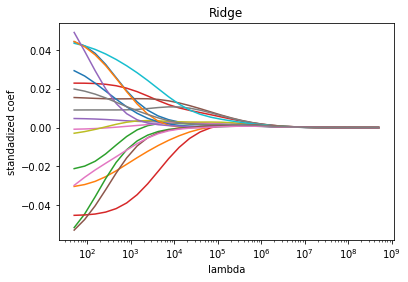

In [69]:
%%time
%matplotlib inline
ax = plt.gca() # Get the current Axes instance
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda') 
plt.ylabel('standadized coef') 
plt.title('Ridge')
plt.savefig('ridge.png')

In [70]:
alphas = 10**np.linspace(-5,0,30)*0.5

In [71]:
%%time
# sometimes this cell takes a long time
lasso = Lasso(max_iter=10000) 
coefs = [] 
for a in alphas: 
    lasso.set_params(alpha=a) 
    lasso.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(lasso.coef_) 
# print('Shape:',np.shape(coefs)
print('Selected Features:', list(vars.columns[np.where(lasso.coef_!=0)[0]]))

/Users/chaitanya/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.567e+01, tolerance: 6.127e-02
  model = cd_fast.enet_coordinate_descent(
/Users/chaitanya/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.062e+00, tolerance: 6.127e-02
  model = cd_fast.enet_coordinate_descent(
/Users/chaitanya/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

Selected Features: []
CPU times: user 5min 34s, sys: 25.7 s, total: 6min
Wall time: 48.3 s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


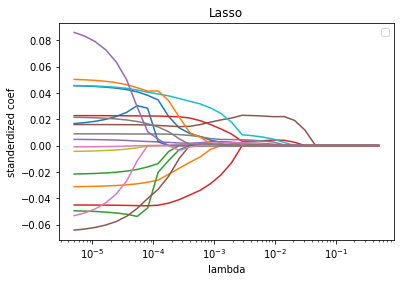

In [72]:
%matplotlib inline
ax = plt.gca() # Get the current Axes instance 
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('standerdized coef') 
plt.title('Lasso')
plt.legend()
plt.savefig('lasso.png')

## Look at PCA

In [73]:
len(X_trntst.columns)

18

In [74]:
X_trntst_save = X_trntst.copy()

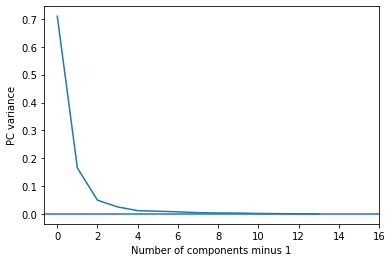

In [75]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [76]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 6, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-1.769485,0.392497,-0.043998,0.172190,-0.001785,-0.021209
1,-1.657164,0.344750,-0.040777,0.153074,-0.002480,-0.020006
2,-1.062950,0.092152,-0.023735,0.051941,-0.006157,-0.013640
3,-1.769062,0.393226,-0.044709,0.171682,-0.001808,-0.021607
4,-1.767876,0.395168,-0.044948,0.171342,-0.001616,-0.022291


In [77]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
87397,-0.008698,0.034339,-0.044689,0.487997,-0.356525,0.111945
87398,-1.523573,0.550331,-0.158052,0.189809,0.031992,0.072992
87399,0.006361,-0.241775,0.592910,-0.522853,0.662153,0.203441
87400,-1.515399,0.560540,-0.159036,0.187100,0.032908,0.068485
87401,0.539183,-0.556941,-0.101655,0.070890,0.082903,-0.123488


In [78]:
X_trntst.describe()

,Cardnum_avg_0,Cardnum_max_0,Cardnum_med_0,Cardnum_total_0,Cardnum_med_1,Cardnum_total_1,Cardnum_med_3,Cardnum_total_3,Merchnum_total_0,Merchnum_total_1,card_merch_avg_0,card_merch_max_0,card_merch_med_0,card_merch_total_0,card_merch_avg_1,card_merch_max_1,card_merch_med_1,card_merch_max_7
count,87397.000000,87397.000000,87397.000000,87397.000000,87397.000000,87397.000000,87397.000000,87397.000000,87397.000000,87397.000000,87397.000000,87397.000000,87397.000000,87397.000000,87397.000000,87397.000000,87397.000000,87397.000000
mean,0.002655,0.001912,0.002776,0.003158,0.002726,0.003480,0.002555,0.003972,0.003400,0.004292,0.001982,0.001533,0.002052,0.001042,0.001905,0.001610,0.001953,0.001888
std,1.000732,1.002834,1.001061,1.041082,0.995436,1.041902,0.998324,1.038588,1.036286,1.038266,0.990664,1.000976,0.989714,1.037735,0.991107,1.007328,0.990295,1.007760
min,-0.541446,-0.483236,-0.530578,-0.216129,-0.552907,-0.195793,-0.575968,-0.247391,-0.273474,-0.256142,-0.496644,-0.450146,-0.497644,-0.201649,-0.496627,-0.428086,-0.496604,-0.448515
25%,-0.483675,-0.436978,-0.477721,-0.198682,-0.487310,-0.179933,-0.495297,-0.224500,-0.241602,-0.228884,-0.454007,-0.411751,-0.454895,-0.184108,-0.452922,-0.391036,-0.453316,-0.406482
50%,-0.320610,-0.297069,-0.321891,-0.152019,-0.312214,-0.135648,-0.304813,-0.161742,-0.176275,-0.164889,-0.318729,-0.292058,-0.320083,-0.141008,-0.315493,-0.279621,-0.316728,-0.284205
75%,0.085304,0.064876,0.067644,-0.016079,0.077086,-0.011030,0.082921,0.008586,-0.002532,0.004644,0.052836,0.033916,0.052292,-0.013707,0.053424,0.033165,0.052345,0.044220
max,38.521624,45.978424,38.973638,63.401894,42.550024,54.036789,47.332410,50.581286,76.237442,70.157818,35.130059,50.735409,35.412857,82.743334,34.998518,46.984773,35.243011,46.385527


In [79]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,-0.109644,-0.028813,-0.018557,0.015110,0.004372,0.014473
std,3.263063,1.200193,0.589087,0.787864,0.460142,0.339431
min,-1.780111,-35.916973,-19.694500,-27.998803,-11.980324,-5.353882
25%,-1.511134,-0.158517,-0.088915,-0.092366,-0.049767,-0.034265
50%,-1.022063,0.238984,-0.033997,0.089512,-0.009140,-0.014873
75%,0.125146,0.379350,0.047242,0.160053,0.001039,0.025163
max,106.889184,12.132321,19.901174,31.930909,14.653819,12.849163


In [80]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
#X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [81]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,8.739700e+04,8.739700e+04,8.739700e+04,8.739700e+04,8.739700e+04,8.739700e+04
mean,-2.304813e-16,1.505966e-17,1.081806e-17,-3.370672e-17,-2.800043e-17,-2.579261e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.934765e-01,-2.771612e+01,-1.946456e+01,-3.259329e+01,-3.529802e+01,-2.935984e+01
25%,-4.252640e-01,-8.809731e-02,-1.146464e-01,-1.588085e-01,-1.280421e-01,-1.089711e-01
50%,-2.765647e-01,1.396695e-01,-3.696582e-02,1.205526e-01,-2.541427e-02,-3.811158e-02
75%,5.643133e-02,2.262716e-01,5.998961e-02,2.277833e-01,-1.801826e-03,6.171792e-02
max,3.686131e+01,6.785299e+01,6.286871e+01,4.603602e+01,4.060021e+01,6.491798e+01


In [82]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,-0.109644,-0.028813,-0.018557,0.015110,0.004372,0.014473
std,3.263063,1.200193,0.589087,0.787864,0.460142,0.339431
min,-1.780111,-35.916973,-19.694500,-27.998803,-11.980324,-5.353882
25%,-1.511134,-0.158517,-0.088915,-0.092366,-0.049767,-0.034265
50%,-1.022063,0.238984,-0.033997,0.089512,-0.009140,-0.014873
75%,0.125146,0.379350,0.047242,0.160053,0.001039,0.025163
max,106.889184,12.132321,19.901174,31.930909,14.653819,12.849163


In [83]:
X_trntst_pca.shape

(87397, 6)

In [84]:
X_oot_orig_pca.shape

(9000, 6)

## Subsample the larger class if desired

In [85]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst#['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.010309278350515464
(1793, 18) 1793


In [86]:
niter = 0
nitermax = 5
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [87]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [569]:
%%time
# Logistic regression

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression(penalty='elasticnet',C=1,solver='saga',l1_ratio = 0.5)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save#['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst#['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot#['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

/Users/chaitanya/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0 0.6133122028526149 0.6074074074074074 0.21518987341772153


/Users/chaitanya/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


1 0.6316639741518578 0.5567375886524822 0.21518987341772153


/Users/chaitanya/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


2 0.609984399375975 0.5961538461538461 0.21518987341772153


/Users/chaitanya/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


3 0.6068515497553018 0.6006944444444444 0.20253164556962025
4 0.6191222570532915 0.5817490494296578 0.21518987341772153
trn    0.616187
tst    0.588548
oot    0.212658
dtype: float64
CPU times: user 9.78 s, sys: 1.4 s, total: 11.2 s
Wall time: 5.44 s


/Users/chaitanya/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [44]:
%%time
# Single DT

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(criterion='entropy', max_depth=10,min_samples_split=200,min_samples_leaf=4,splitter="random")
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save#['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst#['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot#['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.602803738317757 0.5945945945945946 0.3037974683544304
1 0.6267496111975117 0.6395348837209303 0.35443037974683544
2 0.5957792207792207 0.5789473684210527 0.34810126582278483
3 0.606973058637084 0.6 0.37341772151898733
4 0.6342229199372057 0.5643939393939394 0.3670886075949367
trn    0.613306
tst    0.595494
oot    0.349367
dtype: float64
CPU times: user 1.09 s, sys: 308 ms, total: 1.4 s
Wall time: 205 ms


In [45]:
%%time
# RF

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier(n_estimators=100,max_depth=5,min_samples_split=2,min_samples_leaf=1,max_features=4, criterion="gini")
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save#['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst#['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot#['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6223241590214067 0.5668016194331984 0.43037974683544306
1 0.6139534883720931 0.61328125 0.43670886075949367
2 0.6098726114649682 0.6007326007326007 0.43037974683544306
3 0.6145339652448657 0.6194029850746269 0.43037974683544306
4 0.6108452950558214 0.6167883211678832 0.4240506329113924
trn    0.614306
tst    0.603401
oot    0.430380
dtype: float64
CPU times: user 32.6 s, sys: 80.2 ms, total: 32.6 s
Wall time: 32.6 s


In [46]:
%%time
# LGBM

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(boosting_type = 'gbdt',max_depth=-1,n_estimators =100,subsample=1,colsample_bytree =1, learning_rate = 0.1,num_leaves=2)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save#['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst#['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot#['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6126984126984127 0.5498154981549815 0.3924050632911392
1 0.6012364760432767 0.562992125984252 0.3860759493670886
2 0.582018927444795 0.5955056179775281 0.3860759493670886
3 0.5874799357945425 0.6187050359712231 0.4177215189873418
4 0.5854430379746836 0.5799256505576208 0.379746835443038
trn    0.593775
tst    0.581389
oot    0.392405
dtype: float64
CPU times: user 4.19 s, sys: 531 ms, total: 4.72 s
Wall time: 634 ms


In [104]:
%%time
# NN

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(activation='logistic', solver='adam', hidden_layer_sizes=(10), max_iter=100, learning_rate='adaptive', alpha=0.03)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save#['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst#['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot#['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5615763546798029 0.6027397260273972 0.379746835443038
1 0.5793650793650794 0.5793357933579336 0.379746835443038
2 0.5771704180064309 0.5806451612903226 0.3860759493670886
3 0.5825396825396826 0.5719557195571956 0.3924050632911392
4 0.5658093797276853 0.6083333333333333 0.3860759493670886
trn    0.573292
tst    0.588602
oot    0.384810
dtype: float64
CPU times: user 42.1 s, sys: 10.2 s, total: 52.3 s
Wall time: 7.01 s


In [105]:
# %%time
# # NN on pc's

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = MLPClassifier(hidden_layer_sizes=(2))

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save#['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst#['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot#['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['NN_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [106]:
# %%time
# # GBC

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = GradientBoostingClassifier(max_depth=2,n_estimators=5)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save#['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst#['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot#['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['GBC',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [107]:
%%time
# Catboost

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(bootstrap_type = 'Bayesian',l2_leaf_reg = 3, depth=6,verbose=0,learning_rate=0.03, grow_policy="SymmetricTree", random_state=None, min_data_in_leaf=1, iterations=1000)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save#['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst#['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot#['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.7463175122749591 0.6793103448275862 0.33544303797468356
1 0.7703349282296651 0.6496350364963503 0.34810126582278483
2 0.7605633802816901 0.648854961832061 0.34810126582278483
3 0.7833876221498371 0.6202090592334495 0.34177215189873417
4 0.7589424572317263 0.6589147286821705 0.3291139240506329
trn    0.763909
tst    0.651385
oot    0.340506
dtype: float64
CPU times: user 1min 22s, sys: 26 s, total: 1min 48s
Wall time: 24.5 s


In [108]:
# %%time
# # NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# # Only use this cell if you do downsampling of the goods.
# # each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# # it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

# xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
# print(xmult)
# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

#     model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)

#     model.fit(X_trn, Y_trn.values.ravel())  
    
#     X_oot = X_oot_orig.copy()
#     X_trn = X_trntst.copy()
#     Y_trn = Y_trntst.copy()
#     X_tst = X_trntst.copy()
#     Y_tst = Y_trntst.copy()


#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trntst#['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_trntst#['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot#['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost_sampled',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [109]:
# %%time
# # Catboost on pc's

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)


#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [110]:
# %%time
# # unsupervised model using pc's. 

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     pow = 2
#     oop = 1/pow
#     predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save#['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst#['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot#['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['unsupervised outliers',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [111]:
sum(X_trn.loc[:,'Fraud'])

643

In [112]:
%%time
# XGB

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = xgb.XGBClassifier(booster='gbtree',max_depth=6, n_estimators=5, tree_method='auto',min_child_weight=1,colsample_bytree=1,subsample=1,eta=0.3,eval_metric='rmse')

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save#['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst#['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot#['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['XGB',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6514657980456026 0.6236933797909407 0.37341772151898733
1 0.6200317965023847 0.5992647058823529 0.4240506329113924
2 0.6111975116640747 0.6201550387596899 0.43670886075949367
3 0.643879173290938 0.5661764705882353 0.41139240506329117
4 0.6571428571428571 0.5940959409594095 0.36075949367088606
trn    0.636743
tst    0.600677
oot    0.401266
dtype: float64
CPU times: user 4.52 s, sys: 482 ms, total: 5 s
Wall time: 670 ms


In [113]:
# %%time
# # Knn
# # Knn can be very slow with a lot of records.

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = KNeighborsClassifier(n_neighbors=50) 
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['Knn',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [114]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(
#         C=.1, 
# #         gamma=100,
# #         kernel='linear',
#         kernel='poly',
#         probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [115]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.52551,0.539936,0.253165
1,log reg,0.509554,0.593407,0.253165
2,log reg,0.539452,0.557143,0.272152
3,log reg,0.525078,0.558935,0.259494
4,log reg,0.541997,0.514815,0.272152
5,DT,0.602804,0.594595,0.303797
6,DT,0.62675,0.639535,0.35443
7,DT,0.595779,0.578947,0.348101
8,DT,0.606973,0.6,0.373418
9,DT,0.634223,0.564394,0.367089


In [116]:
df.shape

(125, 4)

In [117]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.52551
1,log reg,Trn,0.509554
2,log reg,Trn,0.539452
3,log reg,Trn,0.525078
4,log reg,Trn,0.541997


In [118]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare

,Model,Type,Value
0,log reg,Trn,0.52551
1,log reg,Trn,0.509554
2,log reg,Trn,0.539452
3,log reg,Trn,0.525078
4,log reg,Trn,0.541997
...,...,...,...
370,XGB,OOT,0.373418
371,XGB,OOT,0.424051
372,XGB,OOT,0.436709
373,XGB,OOT,0.411392


In [119]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
               mean       std      mean       std      mean       std
Model                                                                
DT         0.613306  0.016400  0.595494  0.028292  0.349367  0.027369
LGBM       0.733243  0.041699  0.664569  0.033633  0.359981  0.019460
NN         0.522906  0.038854  0.530620  0.055280  0.316456  0.053491
RF         0.614306  0.004901  0.603401  0.021677  0.430380  0.004475
XGB        0.631221  0.013677  0.601954  0.022628  0.403797  0.024652
cat boost  0.759578  0.013227  0.660082  0.026192  0.341772  0.017901
log reg    0.528318  0.013053  0.552847  0.028783  0.262025  0.009599

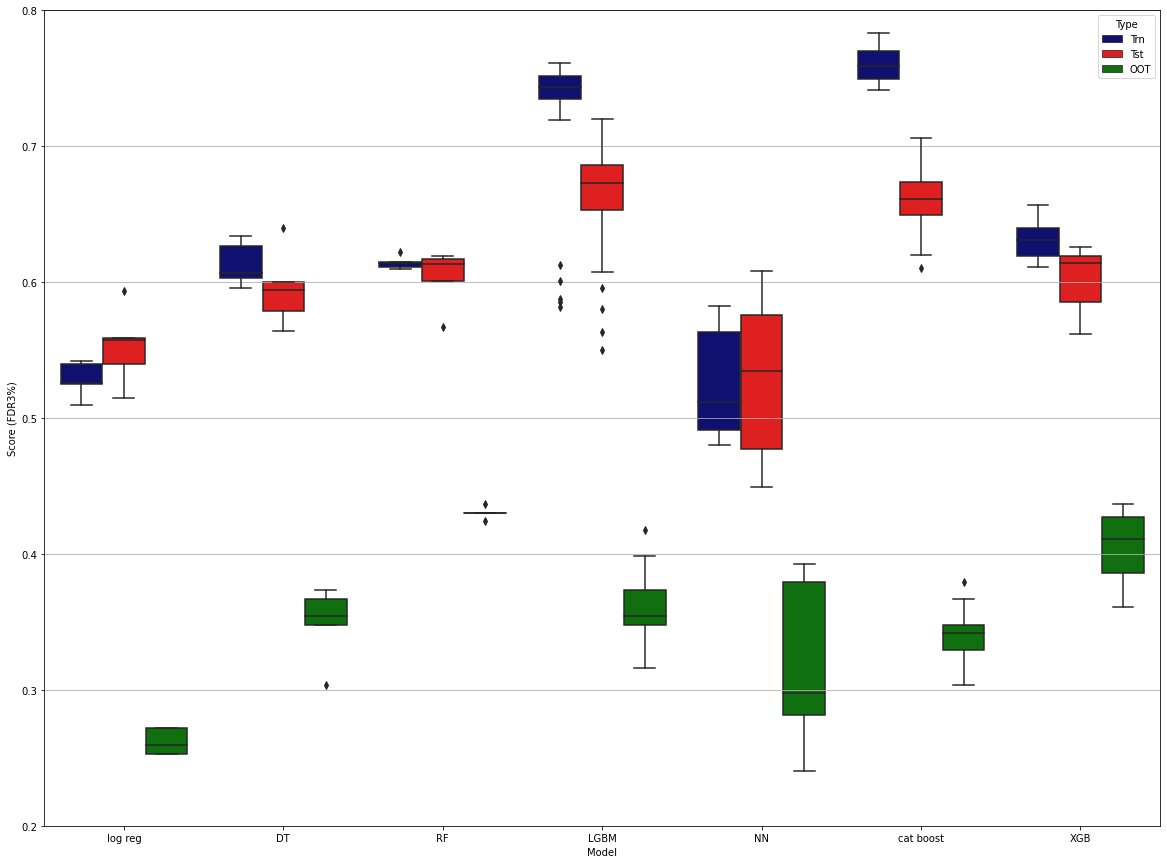

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.2,0.8)
plt.ylabel('Score (FDR3%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [121]:
print('duration: ', datetime.now() - start_time)

duration:  0:15:42.271851


0 0.6421568627450981 0.6470588235294118 0.3227848101265823
1 0.6431226765799256 0.6595744680851063 0.31645569620253167
2 0.6480793060718711 0.6595744680851063 0.31645569620253167
loop trn tst oot 2 0.6444529484656316 0.6554025865665415 0.3185654008438819
0 0.6492537313432836 0.6494845360824743 0.3227848101265823
1 0.6503667481662592 0.6385542168674698 0.3291139240506329
2 0.6444444444444445 0.7032967032967034 0.31645569620253167
loop trn tst oot 4 0.6480216413179957 0.6637784854155492 0.3227848101265823
0 0.6483516483516484 0.6951219512195121 0.310126582278481
1 0.6445264452644527 0.7045454545454546 0.3291139240506329
2 0.6508728179551122 0.6363636363636364 0.31645569620253167
loop trn tst oot 6 0.6479169705237378 0.6786770140428677 0.31856540084388185
0 0.6535626535626535 0.632183908045977 0.310126582278481
1 0.6450809464508095 0.7142857142857143 0.310126582278481
2 0.660996354799514 0.5897435897435898 0.31645569620253167
loop trn tst oot 8 0.6532133182709924 0.6454044040250938 0.3122

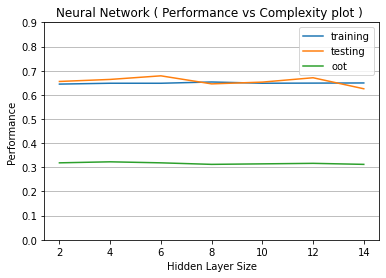

CPU times: user 5min 58s, sys: 1min 22s, total: 7min 20s
Wall time: 57.3 s


In [89]:
%%time
nitermax=3
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(2,16,2):
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = 0.1)
        #model = DecisionTreeClassifier(criterion='entropy', max_depth=i, min_samples_split=20,min_samples_leaf=2,splitter="best")
        #model = lgb.LGBMClassifier(boosting_type = 'gbdt',max_depth=i,n_estimators =80,subsample=1,colsample_bytree =0.8, learning_rate = 0.03,num_leaves=70)
        model = MLPClassifier(activation='logistic', hidden_layer_sizes=(i),solver='adam', 
                      learning_rate='adaptive',learning_rate_init=0.001,alpha=0.03,max_iter=100)
        
        #model = RandomForestClassifier(n_estimators=100,max_depth=i,min_samples_split=500,min_samples_leaf=2,max_features=8, criterion="gini")
        #model = MLPClassifier(activation='relu', hidden_layer_sizes=(i),solver='lbfgs',learning_rate='constant',learning_rate_init=0.0001,alpha=0.2)
        #model = CatBoostClassifier(verbose=False,depth=6,l2_leaf_reg=20, bootstrap_type='Bernoulli',learning_rate=0.01, iterations=400)

        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

    


table=pd.DataFrame({'n': range(2, 16, 2),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
table.plot()

plt.ylim(0,0.9)
plt.grid(axis='y')

plt.xlabel('Hidden Layer Size')
plt.ylabel('Performance')
plt.title('Neural Network ( Performance vs Complexity plot ) ')
plt.savefig('NeuralNetwork.png', format='png')
plt.show()

The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [122]:
%%time

for niter in range(30):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
    model = CatBoostClassifier(verbose=0, iterations=100)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save#['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst#['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot#['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    if(FDR3.loc[niter, 'oot'] > .56): break
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.7449139280125195 0.7213740458015268 0.3291139240506329
1 0.7616099071207431 0.6588235294117647 0.37341772151898733
2 0.7392638036809815 0.6867469879518072 0.35443037974683544
3 0.7198697068403909 0.6585365853658537 0.36075949367088606
4 0.7390625 0.685823754789272 0.34177215189873417
5 0.744408945686901 0.6763636363636364 0.33544303797468356
6 0.7520391517128875 0.6840277777777778 0.36075949367088606
7 0.7339743589743589 0.6787003610108303 0.31645569620253167
8 0.740506329113924 0.620817843866171 0.379746835443038
9 0.759170653907496 0.656934306569343 0.33544303797468356
10 0.731437598736177 0.6567164179104478 0.379746835443038
11 0.7388724035608308 0.6696035242290749 0.3670886075949367
12 0.7579113924050633 0.6617100371747212 0.34810126582278483
13 0.7372742200328407 0.678082191780822 0.35443037974683544
14 0.7411575562700965 0.6594982078853047 0.36075949367088606
15 0.7429906542056075 0.6640926640926641 0.35443037974683544
16 0.7588424437299035 0.6523297491039427 0.34177215189873

In [123]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [124]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,Cardnum_avg_0,Cardnum_max_0,Cardnum_med_0,Cardnum_total_0,Cardnum_med_1,Cardnum_total_1,Cardnum_med_3,Cardnum_total_3,predicted,Fraud
89075,1.360859,3.027937,1.130207,6.231024,1.259171,3.706371,1.438134,3.370145,0.925154,1
89077,1.291690,3.027937,1.100189,6.384901,1.226418,3.799505,1.401730,3.456486,0.925154,1
89074,1.443292,3.027937,1.160225,6.089991,1.291924,3.621009,1.474539,3.291010,0.894267,1
89183,1.290644,7.564255,0.120773,5.216910,0.867784,7.087874,1.003112,6.504998,0.892816,1
89174,1.252206,7.564255,0.119806,4.722993,0.833384,6.788929,0.964877,6.227858,0.892816,1
89134,1.338945,7.564255,0.082288,4.563535,0.867784,6.692416,1.003112,6.138385,0.870486,1
89130,1.472602,7.564255,0.119806,4.476650,0.928743,6.639829,1.070868,6.089634,0.867188,1
96009,4.089578,5.530582,4.152744,1.745752,23.011662,9.756186,9.885527,9.340711,0.823276,0
89186,1.186325,7.564255,0.119806,5.273533,0.833384,7.122145,0.964877,6.536769,0.823070,1
89506,8.307735,5.755616,8.418537,1.658296,9.211446,5.840857,10.276990,5.348939,0.780589,0


In [125]:
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot
    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,90.0,51.0,39.0,56.666667,43.333333,90.0,51.0,39.0,0.576793,24.683544,24.106752,1.307692
2,2.0,90.0,78.0,12.0,86.666667,13.333333,180.0,129.0,51.0,1.458946,32.278481,30.819535,2.529412
3,3.0,90.0,81.0,9.0,90.000000,10.000000,270.0,210.0,60.0,2.375028,37.974684,35.599655,3.500000
4,4.0,90.0,84.0,6.0,93.333333,6.666667,360.0,294.0,66.0,3.325040,41.772152,38.447112,4.454545
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,90.0,90.0,0.0,100.000000,0.000000,8640.0,8482.0,158.0,95.928523,100.000000,4.071477,53.683544
97,97.0,90.0,90.0,0.0,100.000000,0.000000,8730.0,8572.0,158.0,96.946392,100.000000,3.053608,54.253165
98,98.0,90.0,90.0,0.0,100.000000,0.000000,8820.0,8662.0,158.0,97.964261,100.000000,2.035739,54.822785
99,99.0,90.0,90.0,0.0,100.000000,0.000000,8910.0,8752.0,158.0,98.982131,100.000000,1.017869,55.392405


In [126]:
FDR3.to_csv('FDR3.csv')

In [127]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [128]:
print("duration: ", datetime.now() - start_time)

duration:  0:15:51.214870
